In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torchvision import transforms

from datasets.camvid import CamvidDataset, load_dataset
from models.unet import UNet
from utils import display_predictions, display_segmentation

from tqdm import *

In [42]:
from PIL import Image

In [43]:
data_directory = "/share/nikola/export/dt372/camvid"

In [44]:
def load_camvid_dataset(data_directory):
    with open(os.path.join(data_directory, "valid.txt"), "r") as f:
        val_names = [line.strip() for line in f]
    with open(os.path.join(data_directory, "codes.txt"), "r") as f:
        label_mapping = {l.strip(): i for i, l in enumerate(f)}
    data = []
    image_index_mapping = {}
    for im_f in os.listdir(os.path.join(data_directory, "images")):
        if im_f.split('.')[-1] != 'png': continue
        image_index_mapping[im_f] = len(data)
        fp = os.path.join(data_directory, "images", im_f)
        data.append(fp)
    for label_f in os.listdir(os.path.join(data_directory, "labels")):
        im_f = label_f.split('.')
        im_f[0] = '_'.join(im_f[0].split('_')[:-1])
        im_f = '.'.join(im_f)
        index = image_index_mapping[im_f]
        fp = os.path.join(data_directory, "labels", label_f)
        data[index] = (data[index], fp)
    val_indices = [image_index_mapping[name] for name in val_names]
    return data, val_indices, label_mapping
all_data, val_indices, label_mapping = load_camvid_dataset(data_directory);

In [45]:
tr_data, val_data = [tpl for i, tpl in enumerate(all_data) if i not in val_indices], \
                    [tpl for i, tpl in enumerate(all_data) if i in val_indices]

In [46]:
tr_data[0]

('/share/nikola/export/dt372/camvid/images/0016E5_00750.png',
 '/share/nikola/export/dt372/camvid/labels/0016E5_00750_P.png')

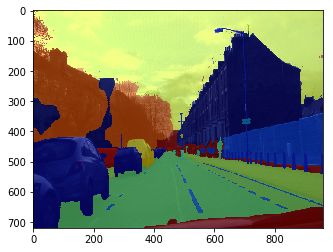

In [47]:
def display_segmentation_from_file(im_f, label_f):
    im, label = Image.open(im_f), Image.open(label_f)
    display_segmentation(im, label)
i = 10
display_segmentation_from_file(tr_data[i][0], tr_data[i][1])

In [48]:
tr_ds, val_ds = CamvidDataset(tr_data), CamvidDataset(val_data, is_train=False)

In [49]:
tr_dl, val_dl = data.DataLoader(tr_ds, shuffle=True), data.DataLoader(val_ds)

In [50]:
def train(model, dataloader, criterion, optimizer, epochs,
          scheduler=None, verbose=False):
    model.train()
    losses = []
    epoch_iter = trange(epochs, position=0) if verbose else range(epochs)
    for epoch in epoch_iter:
        tr_loss, total = 0., 0.
        dl_iter = tqdm_notebook(dataloader, position=1,
                       leave=False) if verbose else dataloader
        for x, y in tqdm_notebook(dataloader, position=1, leave=False):
            optimizer.zero_grad()
            if torch.cuda.is_available():
                x, y = x.cuda(), y.squeeze(dim=1).cuda()
            pred = model(x)
            loss = criterion(pred, y)
            tr_loss += loss.data.cpu()
            total += len(y)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            sys.stdout.flush()
            sys.stdout.write("\rEpoch %d: Loss %.5f" % (epoch + 1, tr_loss / total))
        overall_loss = tr_loss / len(dataloader)
        losses.append(overall_loss)
        if verbose:
            print(overall_loss)
        model.epoch += 1
    return losses

In [51]:
EPOCHS = 20
TOTAL_STEPS = EPOCHS * len(tr_dl)

In [52]:
transposed_model = UNet(3, 3, len(label_mapping), dilated=False)
if torch.cuda.is_available():
    transposed_model = transposed_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(transposed_model.parameters(), lr=1e-3, betas=(0.99, 0.999))
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=TOTAL_STEPS)
transposed_losses = []

Epoch 1: Loss 3.31475

Epoch 2: Loss 2.91175

Epoch 3: Loss 2.48215

Epoch 4: Loss 2.18072

Epoch 5: Loss 2.02230

Epoch 6: Loss 1.76904

Epoch 7: Loss 1.68949

Epoch 8: Loss 1.64332

Epoch 9: Loss 1.60586

Epoch 10: Loss 1.57071

Epoch 11: Loss 1.54404

Epoch 12: Loss 1.52060

Epoch 13: Loss 1.49637

Epoch 14: Loss 1.47856

Epoch 15: Loss 1.45984

Epoch 16: Loss 1.44674

Epoch 17: Loss 1.43548

Epoch 18: Loss 1.42823

Epoch 19: Loss 1.42321

Epoch 20: Loss 1.42067

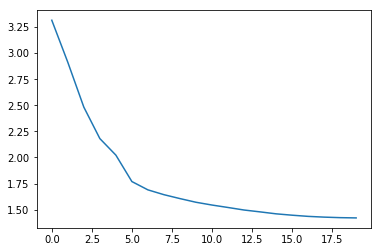

In [53]:
transposed_losses.extend(train(transposed_model, tr_dl, criterion, optimizer, EPOCHS, scheduler=scheduler))
plt.plot(list(range(transposed_model.epoch)), transposed_losses)

In [54]:
dilation_model = UNet(3, 3, len(label_mapping))
if torch.cuda.is_available():
    dilation_model = dilation_model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(dilation_model.parameters(), lr=1e-3, betas=(0.99, 0.999))
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, total_steps=TOTAL_STEPS)
dilated_losses = []

Epoch 1: Loss 3.09502

Epoch 2: Loss 2.66997

Epoch 3: Loss 2.01709

Epoch 4: Loss 1.49944

Epoch 5: Loss 1.33571

Epoch 6: Loss 1.21296

Epoch 7: Loss 1.12710

Epoch 8: Loss 1.05083

Epoch 9: Loss 1.00535

Epoch 10: Loss 0.97486

Epoch 11: Loss 0.94223

Epoch 12: Loss 0.92269

Epoch 13: Loss 0.89013

Epoch 14: Loss 0.85812

Epoch 15: Loss 0.83249

Epoch 16: Loss 0.81384

Epoch 17: Loss 0.79738

Epoch 18: Loss 0.78481

Epoch 19: Loss 0.77816

Epoch 20: Loss 0.77430

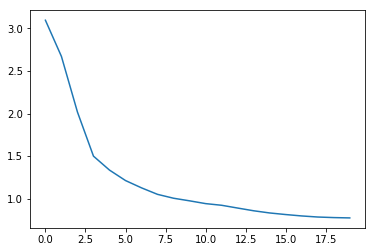

In [55]:
dilated_losses.extend(train(dilation_model, tr_dl, criterion, optimizer, EPOCHS, scheduler=scheduler))
plt.plot(list(range(dilation_model.epoch)), dilated_losses)

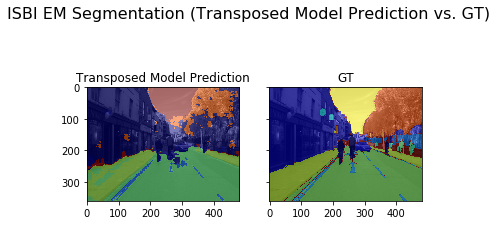

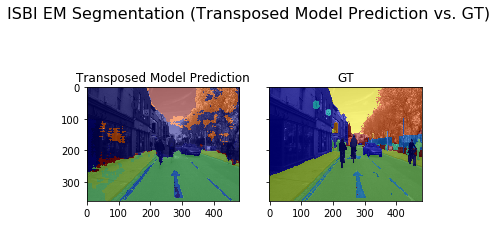

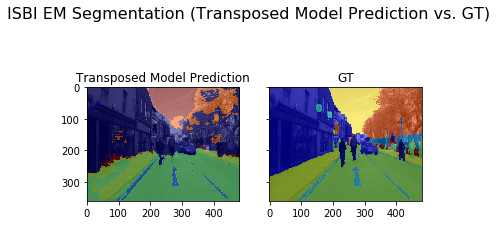

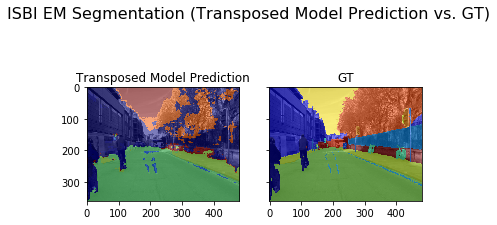

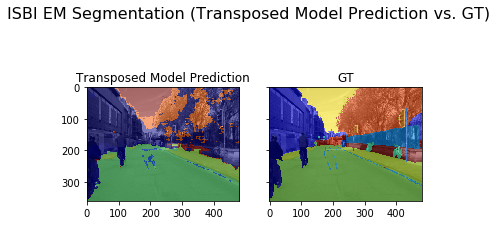

In [60]:
display_predictions(transposed_model, val_dl, model_name="Transposed Model")

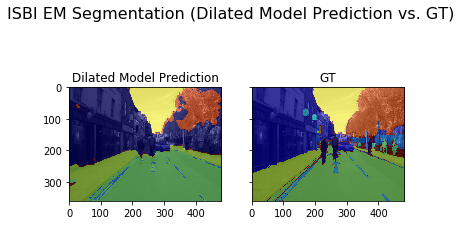

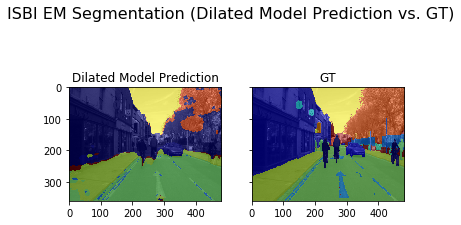

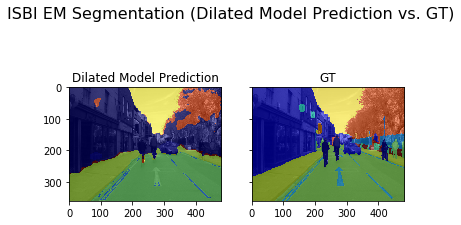

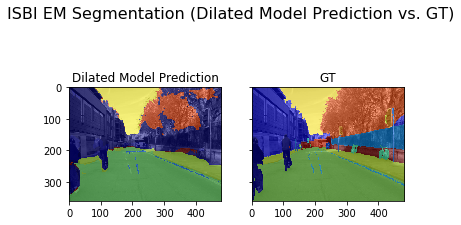

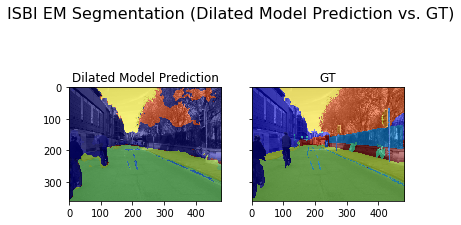

In [61]:
display_predictions(dilation_model, val_dl, model_name="Dilated Model")